# Understanding Neural Networks

### Load Libraries

In [1]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib
from matplotlib import pyplot as plt

import torch
import torchvision

#### Check Environment

In [2]:
requirements = {
    torch: '1',
    matplotlib: '3'
}

def check_requirements(requirements):
    for requirement in requirements:
        error_message = '{} environment does not match requirement'.format(requirement.__name__)
        assert (requirement.__version__[0] == requirements[requirement]), error_message

check_requirements(requirements)

#### Load Model

In [3]:
resnet50 = torchvision.models.resnet50(pretrained=True)

### Useful Functions

In [4]:
class PlotGrid:
    def __init__(self, figsize=None):
        self.fig = plt.figure(figsize=figsize)
        self.ax = {}
    
    def plot(self, position_id, data, title=None, xlim=None, ylim=None):
        if position_id in self.ax:
            ax = self.ax[position_id]
        else:
            ax = self.fig.add_subplot(position_id)

        # cache current values
        if title is None:
            title = ax.get_title()

        if xlim is None:
            xlim = ax.get_xlim()

        if ylim is None:
            ylim = ax.get_ylim()

        ax.clear()
        ax.plot(data.numpy())
        ax.fill_between(range(len(data)), data)
        ax.grid(True)
        
        # set title
        if title is not None:
            ax.set_title(title)
            
        # set xlim
        if xlim is not None:
            ax.set_xlim(*xlim)

        # set ylim
        if ylim is not None:
            ax.set_ylim(*ylim)

        self.fig.show()
        self.fig.canvas.draw()
        self.ax[position_id] = ax


#### Test Functions

<IPython.core.display.Javascript object>


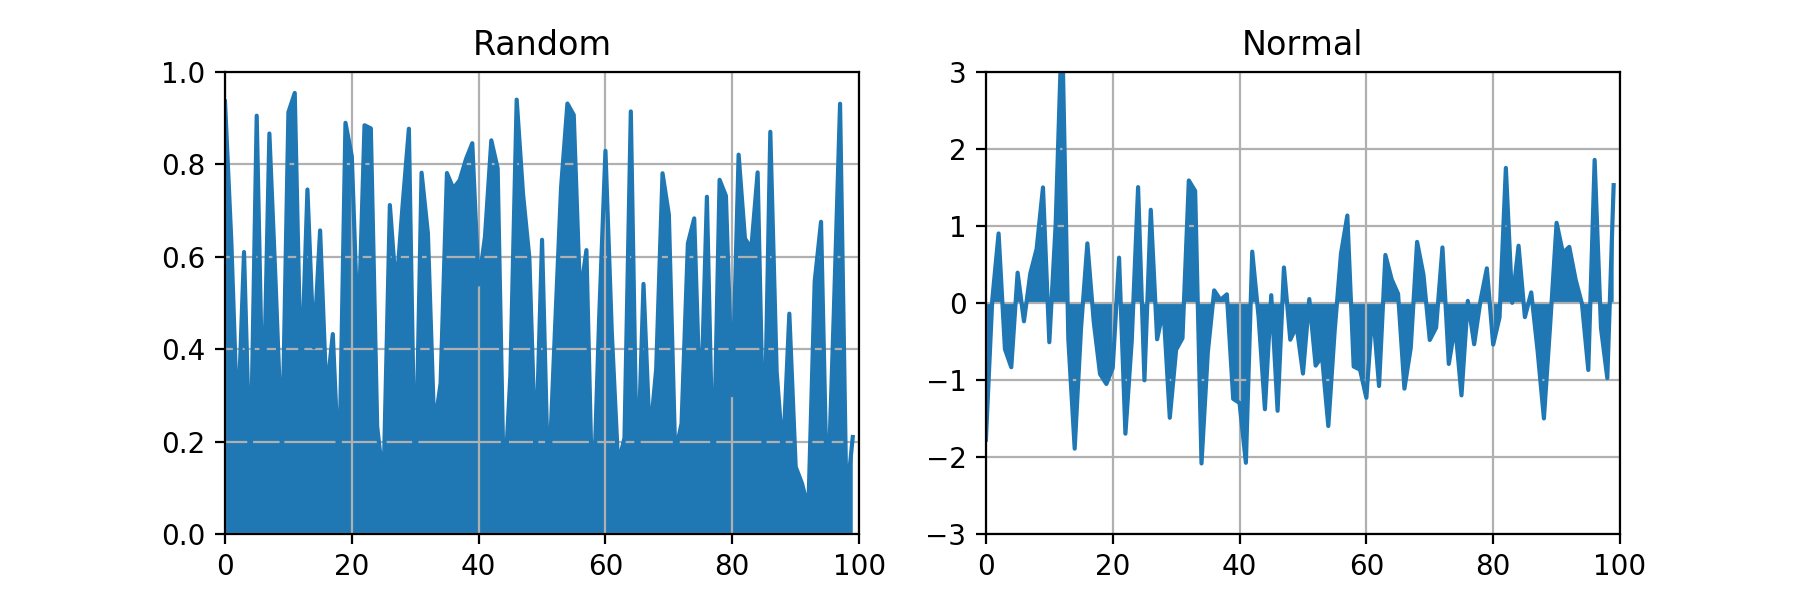

In [5]:
# test plotting function
plot_grid = PlotGrid(figsize=(9,3))

# initialize figures
# random
data = torch.rand((100))
plot_grid.plot(121, data, title='Random', xlim=(0, len(data)), ylim=(0, 1.0))
# normal
data = torch.randn((100))
plot_grid.plot(122, data, title='Normal', xlim=(0, len(data)), ylim=(-3.0, 3.0))

In [6]:
# update plots

for i in range(10):
    # random
    data = torch.rand((100))
    plot_grid.plot(121, data)
    # normal
    data = torch.randn((100))
    plot_grid.plot(122, data)